# TP - Non-parametric regression (Cubic splines)
<h4 align="right"> Author: Hicham Janati </h4>

The motorcycle dataset records the head's acceleration after an accident as a function of time. Download and visualize the data:

## **Cécile TILLEROT - Hugo QUENIAT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


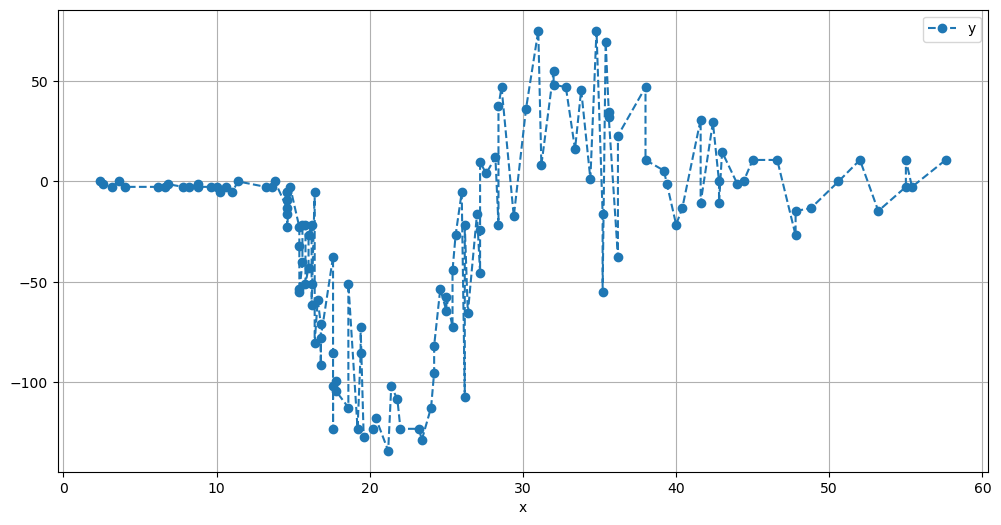

In [2]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
ax.grid()

#### Question 1
Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

In [3]:
# Transform the date to (x,y,w)

df = df_raw.groupby("x").agg({"y": "mean", "x": "size"})
df.columns = ["y'", "count"]
df["w"] = 1 / df["count"]
df = df.reset_index()
print(df)


       x    y'  count    w
0    2.4   0.0      1  1.0
1    2.6  -1.3      1  1.0
2    3.2  -2.7      1  1.0
3    3.6   0.0      1  1.0
4    4.0  -2.7      1  1.0
..   ...   ...    ...  ...
89  52.0  10.7      1  1.0
90  53.2 -14.7      1  1.0
91  55.0   4.0      2  0.5
92  55.4  -2.7      1  1.0
93  57.6  10.7      1  1.0

[94 rows x 4 columns]


In [4]:
x = np.asarray(df["x"].values)
y = np.asarray(df["y'"].values)
w = np.asarray(df["w"].values)

### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

#### Question 2
Perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?


**Answer :** Increasing the degree may not increase the performance of the algorithm. As we can see, there is overfitting, to the point where it only follows the curve given, because there are enough points to place for it to match perfectly the samples. Another problem we encounter is computational. If we go over a degree of 200, the SVD does not converge, and it becomes very costly.

/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


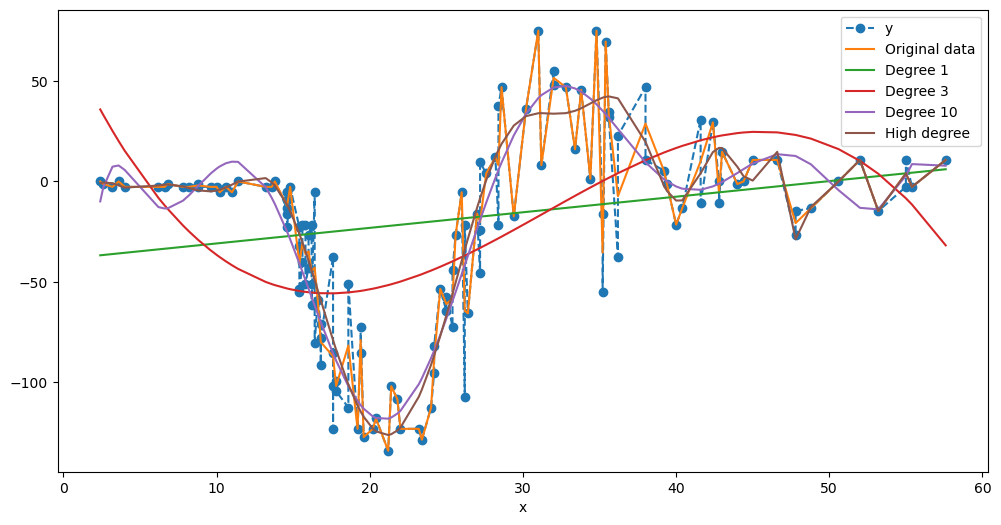

In [5]:
# Determining the coeffs of the polynomial for a fit of degree 1, 3, 10, 150

coeffs1 = np.polyfit(x, y, 1, w=w)
coeffs3 = np.polyfit(x, y, 3, w=w)
coeffs10 = np.polyfit(x, y, 10, w=w)
coeffs_high = np.polyfit(x, y, 150, w=w)

# Producing the polynomial functions

poly1 = np.poly1d(coeffs1)
poly3 = np.poly1d(coeffs3)
poly10 = np.poly1d(coeffs10)
poly_high = np.poly1d(coeffs_high)

# Predicting the values

y_pred1 = poly1(x)
y_pred3 = poly3(x)
y_pred10 = poly10(x)
y_pred_high = poly_high(x)

# Plotting

df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
plt.plot(x, y, label='Original data')
plt.plot(x, y_pred1, label='Degree 1')
plt.plot(x, y_pred3, label='Degree 3')
plt.plot(x, y_pred10, label='Degree 10')
plt.plot(x, y_pred_high, label='High degree')
plt.legend()
plt.show()

/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/hugoqueniat/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


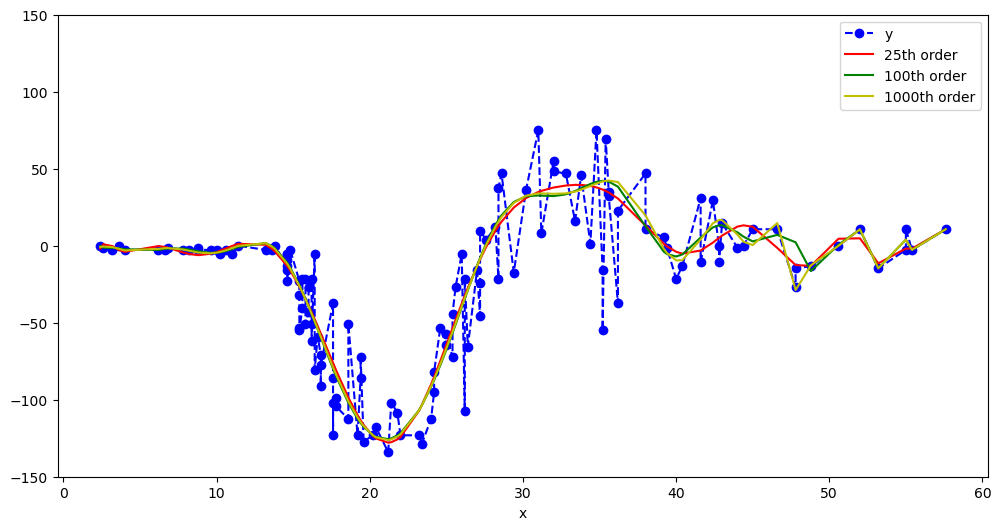

In [6]:
# Higher order polynomial regression

df_raw.plot("x", "y", marker="o", ls="--", ax=plt.gca(), color="b", figsize=(12, 6))
plt.plot(x, np.polyval(np.polyfit(df["x"], df["y'"], 25, w=df["w"]), x), label="25th order", color="r")
plt.plot(x, np.polyval(np.polyfit(df["x"], df["y'"], 50, w=df["w"]), x), label="100th order", color="g")
plt.plot(x, np.polyval(np.polyfit(df["x"], df["y'"], 100, w=df["w"]), x), label="1000th order", color="y")
plt.ylim(-150, 150)
plt.legend()
plt.show()

## Cubic spline regression
#### Question 3
Complete the function `solve_splines_naive` that computes $g$ and $\gamma$ given the data. 

#### Question 4 
Knowing that $R + \alpha Q^\top Q$ is invertible, write an implementation of `solve_splines` that performs 0 matrix inversions.

In [7]:
def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
	# Application of the formula seen in class
    W = np.diag(weights)
    R, Q = _construct_R_Q(x)
    R_inv = np.linalg.inv(R)
    K = Q @ R_inv @ Q.T
    A = W + alpha * K
    g = np.linalg.solve(A, W @ y)
    gamma = R_inv @ Q.T @ g
    
    
    return g, gamma

import scipy.linalg as la

def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    W = np.diag(weights)
    W_i = np.diag(1 / weights)
    R , Q = _construct_R_Q(x)
    n = len(y)
    QTy = np.zeros(n-2)
    for i in range(1, n-1): # We compute Q.T @ Y efficiently
        QTy[i-1] = (y[i+1] - y[i]) / (x[i+1] - x[i]) - (y[i] - y[i-1]) / (x[i] - x[i-1])
    A = R + alpha * Q.T @ W_i @ Q
    gamma = la.cho_solve(la.cho_factor(A), QTy) # We solve through cholesky decomposition because of the inversibility
    g = y - alpha * W_i @ Q @ gamma
 
    return g, gamma

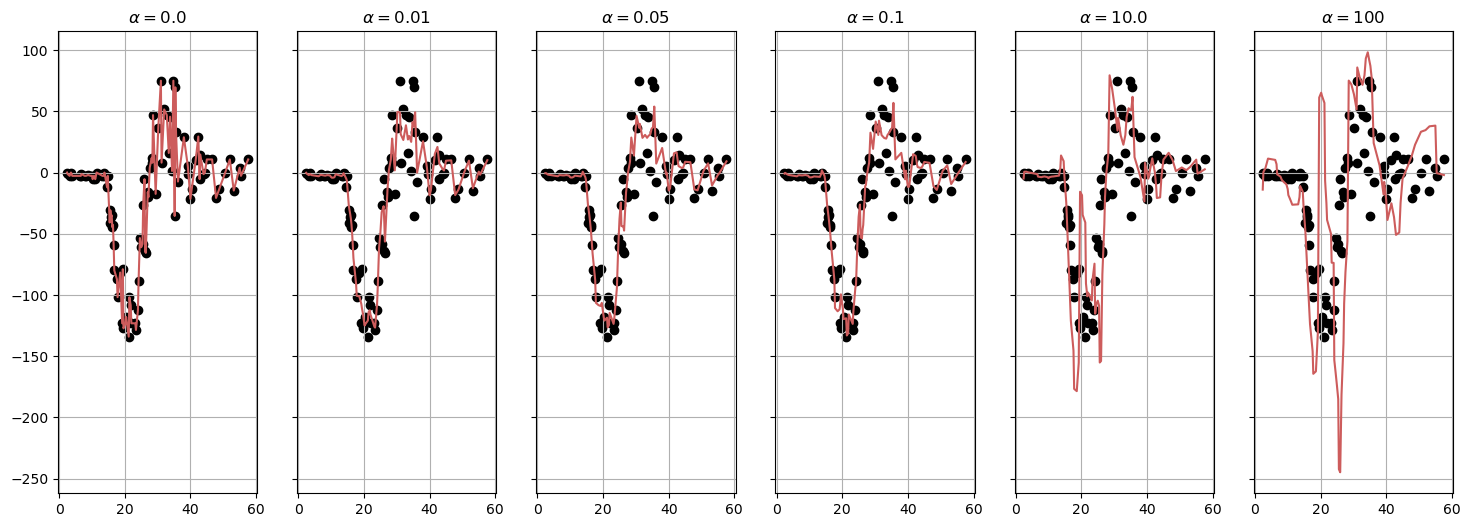

In [8]:
import time

alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

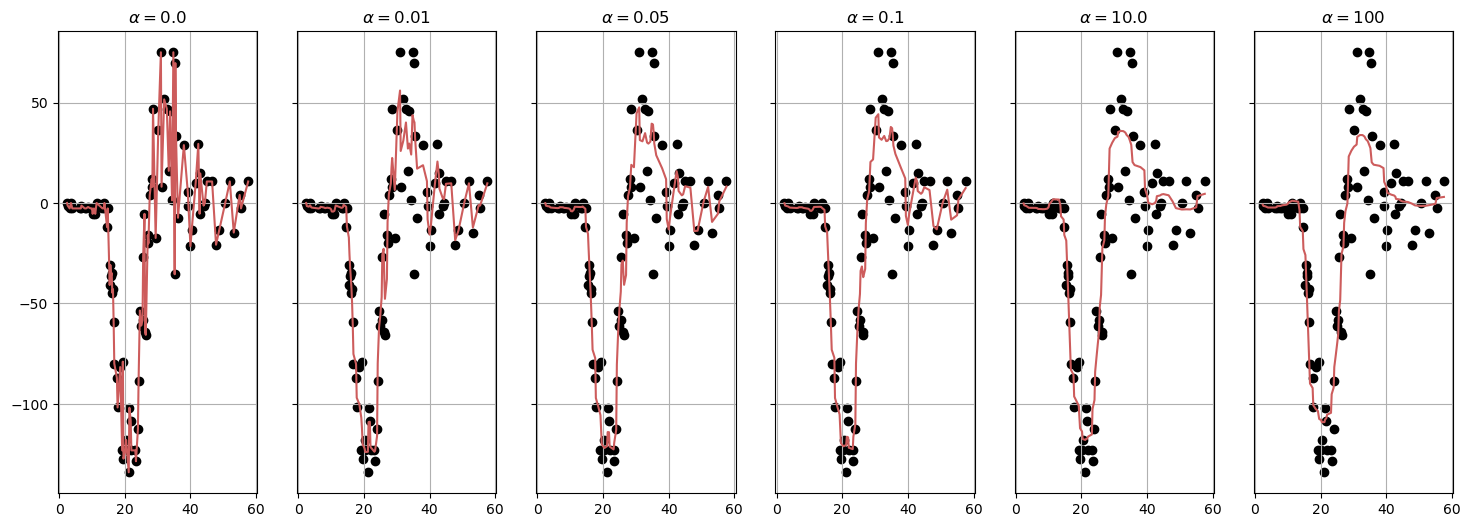

In [9]:
alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines_naive(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

#### Question 5
Implement a GCV function that returns the GCV score. Visualize the GCV score as a function of alpha.

In [10]:
# GCV score

def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""
    W = np.diag(weights)
    n = len(y)
    W_i = np.diag(1 / weights)
    R, Q = _construct_R_Q(x)
    R_inv = np.linalg.inv(R)
    K = Q @ R_inv @ Q.T
    alpha_len = len(alphas)
    gcv_alpha = np.zeros(alpha_len)
    for i  in range(alpha_len):
        g , gamma = solve_splines_naive(x, y, weights, alpha=0.1)
        A = np.linalg.inv(W + alphas[i] * K) @ W
        g = A @ y
        e = y - g
        for j in range(n):
            gcv_alpha[i] += weights[j] * e[j]**2
        gcv_alpha[i] /= (1 - np.trace(A)/n)**2
    return gcv_alpha

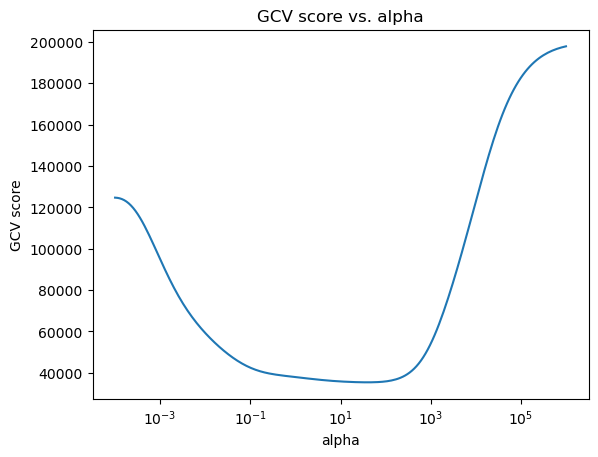

In [11]:
# Testing several values of alpha

alphas = np.logspace(-4, 6, num=200)
gcv_scores = gcv(x, y, w, alphas)
plt.semilogx(alphas, gcv_scores)
plt.xlabel('alpha')
plt.ylabel('GCV score')
plt.title('GCV score vs. alpha')
plt.show() 

### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 

#### Question 6
Fill the class below and find the best Polynomial fit:


In [12]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        self.coeff = None
        
    def fit(self, x, y, weights=None):

        # todo
        self.coeff = np.polyfit(x, y, self.degree, w=weights)
        return self

    def predict(self, x):
        # todo
        y = np.polyval(self.coeff, x)
        return y

params = {"degree": np.arange(16)}

# Cross-validation over the polynomial degree
cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y)

# Display the best degree
poly_cv.best_estimator_

PolynomialFit(degree=8)

#### Question 7
See the content of `poly_cv.cv_results_` and plot the mean CV score as a function of the degree. 

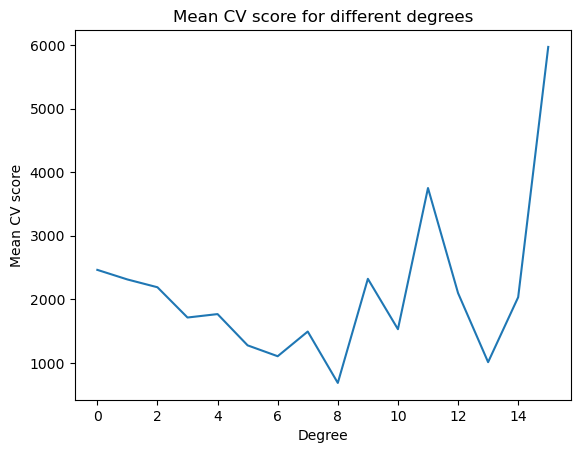

In [13]:
# Plot the mean CV score for each degree

plt.plot(params["degree"], -poly_cv.cv_results_["mean_test_score"])
plt.xlabel("Degree")
plt.ylabel("Mean CV score")
plt.title("Mean CV score for different degrees")
plt.show()

#### Question 8
Visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

Best alpha for cubic spline:  37.83462617131933


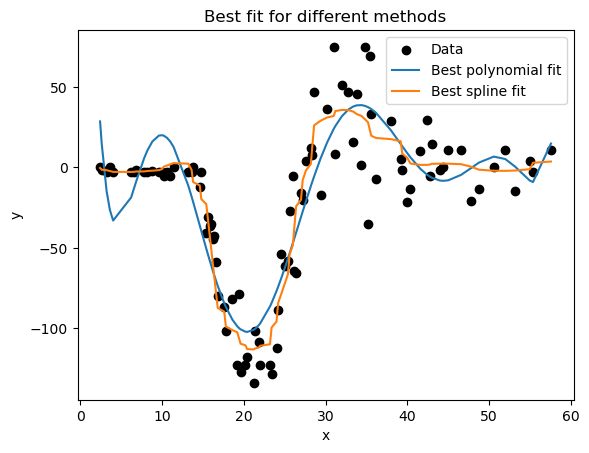

In [14]:
# Visualize the best fit for each method


# Data
plt.scatter(x, y, label="Data", color="k")

# Best polynomial fit
plt.plot(x, poly_cv.best_estimator_.predict(x), label="Best polynomial fit")

# best cubic spline
alpha_gcv = alphas[np.argmin(gcv_scores)]
print("Best alpha for cubic spline: ", alpha_gcv)
g , gamma = solve_splines_naive(x, y, w, alpha=alpha_gcv)
plt.plot(x, g, label="Best spline fit")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Best fit for different methods")
plt.show()

#### Question 9
Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, write a model that performs a polynomial.

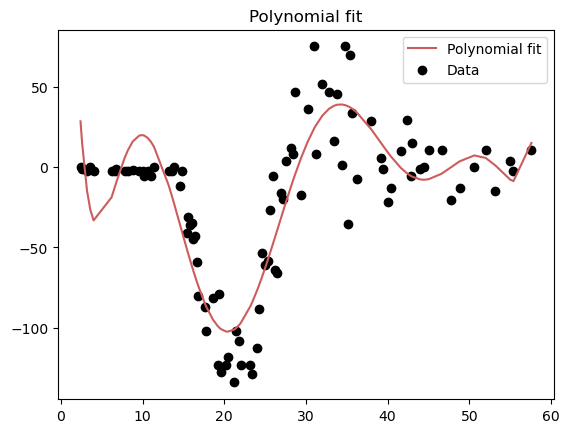

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# Setting up the pipeLine
pipe =Pipeline([
		("poly", PolynomialFeatures(degree=8)),
		("linear", LinearRegression())
	])

newx = x.reshape(-1,1)
pipe.fit(newx, y)


plt.plot(newx, pipe.predict(newx), label="Polynomial fit", color="indianred")
plt.scatter(x, y, label="Data", color="k")
plt.title("Polynomial fit")
plt.legend()
plt.show()

#### Question 10
Perform cross validation on the degree of this model using scikit-learn.

In [16]:
# CV on the degree of the polynomial model

params = {"poly__degree": np.arange(16)}
degree_cv = GridSearchCV(pipe, params, cv=cv, scoring="neg_mean_squared_error")
degree_cv.fit(newx, y)
degree_cv.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=8)),
                ('linear', LinearRegression())])

We find the same best degree as in Question 8.

#### Question 11
Find the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data point $x$. Visualize it on a grid of a few hundred regular points.

We know that the NCS solution with knots $(x_1, ..., x_n)$ is a twice differentiable function such that:

1. $g$ is a piecewise polynomial function of degree 3 with knots at $x_1, ..., x_n$.

2. $g$ is a linear function outside the knots.

3. $g$ is continuous and has continuous first and second derivatives at its knots.

We can use all this facts with the vectors $\textbf{g} and \gamma$ to estimate the NCS on any point $x$ in the interval $[x_1, x_n]$.

Let's name $P_i$ the cubic polynomial associated to the interval $[x_i, x_{i+1}]$ such that $ \forall x \in [x_i, x_{i+1}]$, $P_i(x) = g_i(x)$. Since $P_i$ is a cubic polynomial, we know its second derivative is linear and we know its value at the knots $x_i$ and $x_{i+1}$.

Thus, we can use Lagrange interpolation to write with $h_i = x_{i+1} - x_i$ :
$$ P_i''(x) = g''(x_i) \frac{x_{i+1} - x}{h_i} + g''(x_{i+1}) \frac{x - x_i}{h_i}$$

Then we integrate twice to get $P_i$ :

$$ P_i'(x) = \frac{1}{2} g''(x_i) \frac{(x_{i+1} - x)^2}{h_i} + \frac{1}{2} g''(x_{i+1}) \frac{(x - x_i)^2}{h_i} + c $$

$$ P_i(x) = \frac{1}{6} g''(x_i) \frac{(x_{i+1} - x)^3}{h_i} + \frac{1}{6} g''(x_{i+1}) \frac{(x - x_i)^3}{h_i} + c_1 x + c_2 $$

We can determine $c_1$ and $c_2$ by imposing $P_i(x_i) = y_i$ and $P_i(x_{i+1}) = y_{i+1}$.

We thus find the following system :

$$ c_1 x_i + c_2 + g''(x_i) \frac{(x_{i+1} - x_i)^2}{6}= g(x_i)$$	

$$ c_1 x_{i+1} + c_2 + g''(x_{i+1}) \frac{(x_{i+1} - x_i)^2}{6}= g(x_{i+1}) $$

And since $x_i \neq x_{i+1}$, we can solve the system to find $c_1$ and $c_2$ (the matrix of the system is invertible).

Finally,

$$ c_1 = \frac{g(x_{i+1}) - g(x_i)}{h_i} + \frac{g''(x_i) - g''(x_{i+1})}{6}h_i$$

$$ c_2 = \frac{1}{h_i} (x_{i+1}g(x_i) - x_i g(x_{i+1})) + \frac{h_i}{6} (x_ig''(x_{i+1}) - x_{i+1}g''(x_i))$$

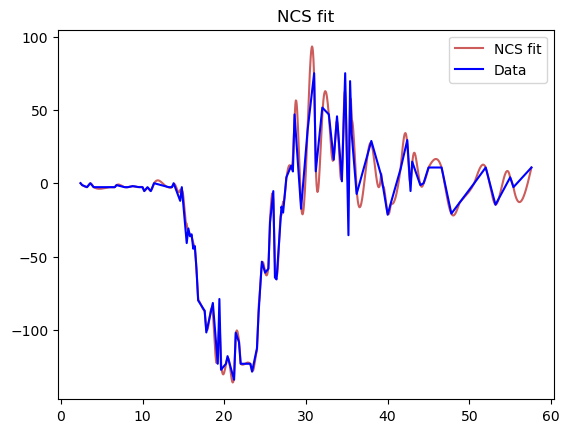

In [17]:
# Predict the value of y for a given x wia the NCS model

def ncs_predict(x, y, w, point_to_predict):
    # Find the interval where the point to predict is
    i = 0
    while point_to_predict > x[i]:
        i += 1
    g, gamma = solve_splines_naive(x, y, w, alpha=alphas[13])
    gamma_alt = np.zeros(len(gamma) + 2)
    # The gamma we got does not include the values (0) at x_1 and x_n
    for j in range(len(gamma)):
        gamma_alt[j+1] = gamma[j]
    # Compute the coefficients of the cubic spline
    h_i = x[i] - x[i-1]
    c_1  = (g[i] - g[i-1]) / h_i + h_i * (gamma_alt[i-1] - gamma_alt[i]) / 6
    c_2 = (x[i] * g[i-1] - x[i-1] * g[i]) / h_i + h_i * (x[i-1] * gamma_alt[i] - x[i] * gamma_alt[i-1]) / 6
    
    return gamma_alt[i-1] * (x[i] - point_to_predict)**3 / (6 * h_i) + gamma_alt[i] * (point_to_predict - x[i-1])**3 / (6 * h_i) + c_1 * point_to_predict + c_2


# Space of values to predict
z = np.linspace(min(x), max(x), 1000)

plt.plot(z, [ncs_predict(x, y, w, point_to_predict) for point_to_predict in z], label="NCS fit", color="indianred")
plt.plot(x, y, label="Data", color="b")
plt.legend()
plt.title("NCS fit")
plt.show()
    
  


